# Exercício 4: Supernovas Ia e distância de luminosidade

## Carregando os dados

In [1]:
import corner
import emcee
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy.integrate import quad
from scipy.optimize import minimize, brentq

%matplotlib inline

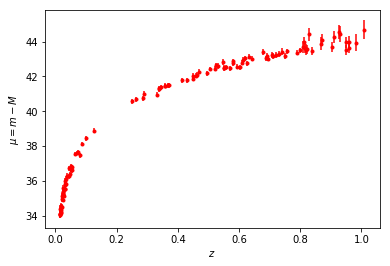

In [2]:
# Loading data
z_obs, m_obs, dm_obs_stat = np.loadtxt("Legacy.dat", unpack=True)

# Systematic error
dm_syst = 0.0169

# Combining errors
dm_obs = np.sqrt(dm_syst + dm_obs_stat ** 2)

# Checking
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu = m - M$")
plt.errorbar(z_obs, m_obs, dm_obs, fmt='r.' );

## Funções para modelar $\mu$ em função de $z$, $\Omega_{m0}$, $\Omega_{r0}$ e $h$

In [3]:
def luminosity_integrand(z, omgM, omgR):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3) + omgR * np.power(1 + z, 4))
    return 1. / Ez

def luminosity_distance(z, h, omgM, omgR):
    integral, _ = quad(luminosity_integrand, 0, z, epsrel=1e-8, args=(omgM, omgR))
    return (cte.c / 10. ** 5) / h * (1 + z) * integral

def distance_modulus(z, h, omgM, omgR):
    return 5. * np.log10(luminosity_distance(z, h, omgM, omgR)) + 25.

## $\chi^2$ em função de $\Omega_{m0}$ e $\Omega_{r0}$
(para o dataset carregado previamente)

In [4]:
def chisq(h, omgM, omgR):
    m_model = np.array([distance_modulus(z, h, omgM, omgR) for z in z_obs])
    chisq_vec = np.power(((m_model - m_obs) / dm_obs), 2)
    return chisq_vec.sum()

## Soluções de máxima verossimilhança

### Variando apenas $h$
Aqui fixamos $\Omega_{m0} = \Omega_{m0,fid} = 0.3$ e $\Omega_{r0} = \Omega_{r0, fid} = 8.4 \cdot 10^{-5}$

In [5]:
# fiducial model parameters
h_fid = 0.73
omgM_fid = 0.3
omgR_fid = 8.4e-5


# Maximum likelihood solution for omg_M and omg_R fixed at fiducial values
chisq_h = np.vectorize(lambda h: chisq(h, omgM_fid, omgR_fid))
result_h = minimize(chisq_h, h_fid, bounds=[(0.01, 1.)])
h_best, = result_h.x
print("Convergiu?: ", result_h.success)
print("chisq / dof = ", result_h.fun[0] / (len(z_obs) - 1))
print("h = ", h_best)

Convergiu?:  True
chisq / dof =  1.0064239678327107
h =  0.6940087135762346


Encontramos $h = 0.6940$

### Variando apenas $\Omega_{m0}$
Aqui fixamos $h = h_{fid} = 0.73$ e $\Omega_{r0} = \Omega_{r0, fid} = 8.4 \cdot 10^{-5}$

In [6]:
# Maximum likelihood solution for h_fid and omg_R fixed at fiducial values
chisq_omgM = np.vectorize(lambda omgM: chisq(h_fid, omgM, omgR_fid))
result_omgM = minimize(chisq_omgM, omgM_fid, bounds=[(0.01, 1.)])
omgM_best, = result_omgM.x
print("Convergiu?: ", result_omgM.success)
print("chisq / dof = ", result_omgM.fun[0] / (len(z_obs) - 1))
print("omegaM = ",  omgM_best)

Convergiu?:  True
chisq / dof =  1.118862089378226
omegaM =  0.1649359834492663


Encontramos $\Omega_{m0} = 0.1649$ (muito distante do valor típico)

### Variando $\Omega_{m0}$ e $h$
Aqui fixamos apenas $\Omega_{r0} = \Omega_{r0, fid} = 8.4 \cdot 10^{-5}$

In [7]:
# Maximum likelihood solution for only omg_R fixed at fiducial value
chisq_joint = lambda x: chisq(x[0], x[1], omgR_fid)
result_joint = minimize(chisq_joint, [h_fid, omgM_fid], bounds=((0.001, 1.), (0.001, 1.)),)
h_joint, omgM_joint = result_joint.x
print("Convergiu?: ", result_joint.success)
print("chisq / dof = ", result_joint.fun / (len(z_obs) - 2))
print("h = ", h_joint)
print("omegaM = ",  omgM_joint)

Convergiu?:  True
chisq / dof =  1.0049548210195025
h =  0.700660871694191
omegaM =  0.26039390609437413


Encontramos $\Omega_{m0} = 0.2604$ e $h = 0.7007$, valores mais próximos dos usuais. Aparentemente este dataset não é consistente com a escolha $h_{fid} = 0.73$

## Gráficos

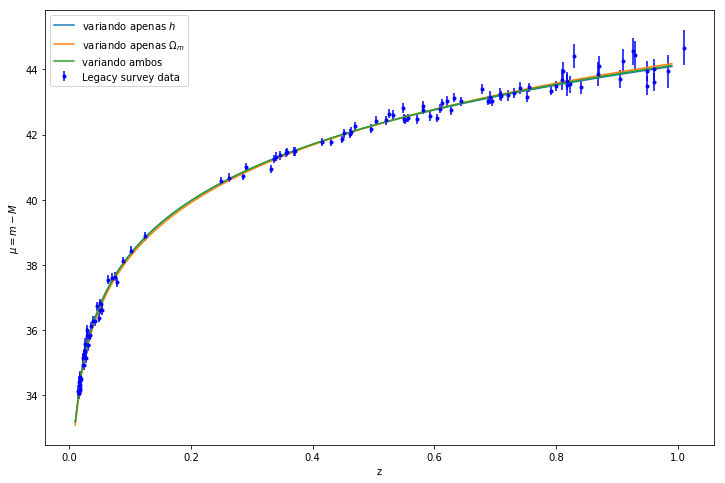

In [8]:
# Plots
zs = np.arange(0.01, 1.0, 0.01)
distance_modulus_best_h = np.vectorize(lambda z : distance_modulus(z, h_best, omgM_fid, omgR_fid))
distance_modulus_best_omgM = np.vectorize(lambda z : distance_modulus(z, h_fid, omgM_best, omgR_fid))
distance_modulus_joint = np.vectorize(lambda z : distance_modulus(z, h_joint, omgM_joint, omgR_fid))

plt.figure(figsize=(12, 8))
plt.xlabel("z")
plt.ylabel(r"$\mu = m - M$")
plt.plot(zs, distance_modulus_best_h(zs), label=r"variando apenas $h$")
plt.plot(zs, distance_modulus_best_omgM(zs), label=r"variando apenas $\Omega_m$")
plt.plot(zs, distance_modulus_joint(zs), label=r"variando ambos")
plt.errorbar(z_obs, m_obs, dm_obs, fmt='b.', label=r"Legacy survey data")
plt.legend();

## Probabilidades a posteriori

### Probabilidades a posteriori para h apenas

In [9]:
# Functions for priors and loglikelihoods
def lnprior(pars):
    h, = pars
    if 0.0 < h:
        return 0.0
    return -np.inf

def lnlike(pars):
    h, = pars
    return -0.5 * chisq(h, omgM_fid, omgR_fid)

def lnprob(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(pars)

In [10]:
max_loglikelihood = lnprob([h_best])
def integral_like(h):
    # multiply by np.exp(-lnprob([h])) to prevent numerical instability
    integral, _ = quad(lambda x: np.exp(lnprob([x]) - max_loglikelihood), 0, h)
    return integral

# by h ~ 0.72 likelihood is already 0

total_int = integral_like(0.72)

# gets p percentile of posterior distribution
def omgM_percentile(p):
    perc = brentq(lambda x: integral_like(x) - p*total_int, 0.68, 0.72)
    return perc

h_16, h_50, h_84 = omgM_percentile(0.16), omgM_percentile(0.5), omgM_percentile(0.84)
print("h = ", h_50, "(-", h_50 - h_16, ")(+", h_84 - h_50, ")")

h =  0.6940409111482829 (- 0.004684881259752527 )(+ 0.004716719565883709 )


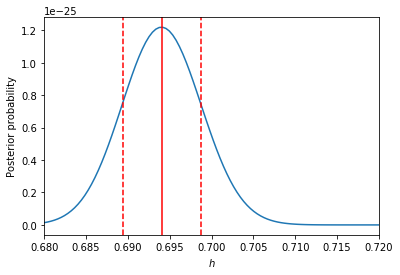

In [11]:
hs = np.linspace(0.68, 0.72, 100)
likelihoods = np.exp([lnprob([x]) for x in hs])

plt.xlabel(r"$h$")
plt.ylabel(r"Posterior probability")
plt.xlim([0.68, 0.72])
plt.plot(hs, likelihoods)
plt.axvline(x=h_16, linestyle="dashed", color="red")
plt.axvline(x=h_84, linestyle="dashed", color="red")
plt.axvline(x=h_50, color="red");

$h = 0.6940^{+0.0047}_{-0.0047}$

### MCMC

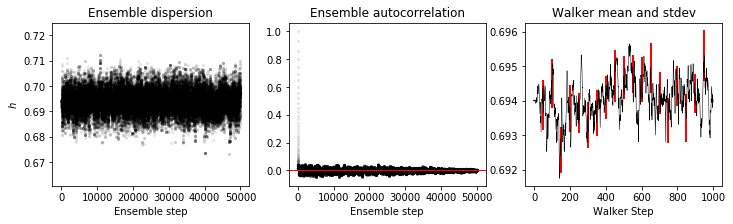

In [12]:
# initial position at maximum likelihood values
ndim, nwalkers, nsteps = 1, 50, 1000
pos = [h_best + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
sampler.run_mcmc(pos, nsteps)

# Getting chain
h_chain = sampler.chain[:,:,0]

# Average and standard deviation between chains
h_chain_mean = np.mean(h_chain, axis=0)
h_chain_std = np.std(h_chain, axis=0) / np.sqrt(nwalkers)

# Reshaping
h_chain_flat = np.reshape(h_chain, (nwalkers*nsteps,))

# Assessing convergence of chain
fig = plt.figure(figsize=(12, 3))
axs = fig.subplots(1, 3)

axs[0].set_xlabel("Ensemble step")
axs[1].set_xlabel("Ensemble step")
axs[2].set_xlabel("Walker Step")
axs[0].set_ylabel(r"$h$")
axs[0].set_title("Ensemble dispersion")
axs[1].set_title("Ensemble autocorrelation")
axs[2].set_title("Walker mean and stdev")
idx = np.arange(len(h_chain_flat))
axs[0].scatter(idx, h_chain_flat[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
# Obtem autocorrelação usando emcee
ac = emcee.autocorr.function(h_chain_flat)

idx = np.arange(len(ac),step=1)
axs[1].scatter(idx, ac[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
axs[1].axhline(alpha=1., lw=1., color='red')

h_chain_mean = np.mean(h_chain, axis=0)
h_chain_err = np.std(h_chain, axis=0) / np.sqrt(nwalkers)
idx = np.arange(len(h_chain_mean))
axs[2].errorbar(x=idx, y=h_chain_mean, yerr=h_chain_err, errorevery=50, ecolor='red',
                lw=0.5, elinewidth=2., color='k');

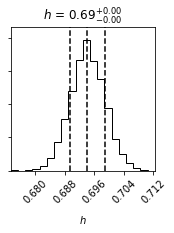

In [13]:
burn = 5000
samples_burned = np.c_[[h_chain_flat[burn:]]]
fig = corner.corner(samples_burned.T, labels=[r"$h$"],
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

In [14]:
# Getting one-sigma intervals
h_perc = np.percentile(h_chain_flat[burn:], [16,50,84])

print(h_perc[1], h_perc[0] - h_perc[1], h_perc[2] - h_perc[1])

0.6940325782780215 -0.0046013130014126435 0.004699521782881688


$h_{MCMC} = 0.6940^{+0.0046}_{-0.0047}$

### Probabilidades a posteriori para $\Omega_{m0}$ apenas

In [15]:
# log-prior probability (flat)
def lnprior(pars):
    omgM, = pars
    if 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

# log likelihood
def lnlike(pars):
    omgM, = pars
    return -0.5 * chisq(h_fid, omgM, omgR_fid)

# log-posterior probability
def lnprob(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(pars)

In [16]:
max_loglikelihood = lnprob([omgM_best])
def integral_like(oM):
    # multiply by np.exp(-lnprob([omgM_best])) to prevent numerical instability
    integral, _ = quad(lambda x: np.exp(lnprob([x]) - max_loglikelihood), 0, oM)
    return integral

# by omgM ~ 0.4 likelihood is already 0

total_int = integral_like(0.4)

# gets p percentile of posterior distribution
def omgM_percentile(p):
    perc = brentq(lambda x: integral_like(x) - p*total_int, 0., 0.4)
    return perc

omegaM_16, omegaM_50, omegaM_84 = omgM_percentile(0.16), omgM_percentile(0.5), omgM_percentile(0.84)
print("omegaM = ", omegaM_50, "(-", omegaM_50 - omegaM_16, ")(+", omegaM_84 - omegaM_50, ")")

omegaM =  0.16551105053882717 (- 0.018452474710034417 )(+ 0.019021249969323223 )


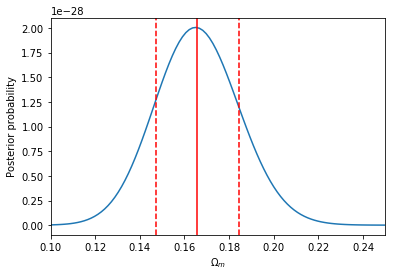

In [17]:
omgMs = np.linspace(0.1, 0.25, 100)
likelihoods = np.exp([lnprob([x]) for x in omgMs])

plt.xlabel(r"$\Omega_{m}$")
plt.ylabel(r"Posterior probability")
plt.xlim([0.1, 0.25])
plt.plot(omgMs, likelihoods)
plt.axvline(x=omegaM_16, linestyle="dashed", color="red")
plt.axvline(x=omegaM_84, linestyle="dashed", color="red")
plt.axvline(x=omegaM_50, color="red");

$\Omega_M = 0.166_{-0.018}^{+0.019}$

### MCMC

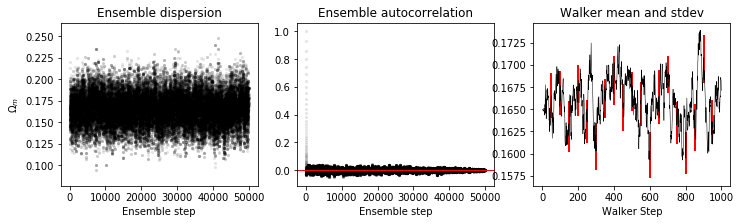

In [18]:
# initial position at maximum likelihood values
ndim, nwalkers, nsteps = 1, 50, 1000
pos = [omgM_best + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
sampler.run_mcmc(pos, nsteps)

# Getting chain
omgM_chain = sampler.chain[:,:,0]

# Average and standard deviation between chains
omgM_chain_mean = np.mean(omgM_chain, axis=0)
omgM_chain_std = np.std(omgM_chain, axis=0) / np.sqrt(nwalkers)

# Reshaping
omgM_chain_flat = np.reshape(omgM_chain, (nwalkers*nsteps,))

# Assessing convergence of chain
fig = plt.figure(figsize=(12, 3))
axs = fig.subplots(1, 3)

axs[0].set_xlabel("Ensemble step")
axs[1].set_xlabel("Ensemble step")
axs[2].set_xlabel("Walker Step")
axs[0].set_ylabel(r"$\Omega_{m}$")
axs[0].set_title("Ensemble dispersion")
axs[1].set_title("Ensemble autocorrelation")
axs[2].set_title("Walker mean and stdev")
idx = np.arange(len(omgM_chain_flat))
axs[0].scatter(idx, omgM_chain_flat[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
# Obtem autocorrelação usando emcee
ac = emcee.autocorr.function(omgM_chain_flat)

idx = np.arange(len(ac),step=1)
axs[1].scatter(idx, ac[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
axs[1].axhline(alpha=1., lw=1., color='red')

omgM_chain_mean = np.mean(omgM_chain, axis=0)
omgM_chain_err = np.std(omgM_chain, axis=0) / np.sqrt(nwalkers)
idx = np.arange(len(omgM_chain_mean))
axs[2].errorbar(x=idx, y=omgM_chain_mean, yerr=omgM_chain_err, errorevery=50, ecolor='red',
                lw=0.5, elinewidth=2., color='k');

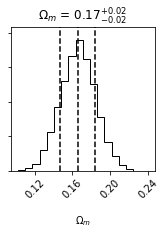

In [19]:
burn = 5000
samples_burned = np.c_[[omgM_chain_flat[burn:]]]
fig = corner.corner(samples_burned.T, labels=[r"$\Omega_m$"],
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

In [20]:
# Getting one-sigma intervals
omgM_perc = np.percentile(omgM_chain_flat[burn:], [16,50,84])

print(omgM_perc[1], omgM_perc[0] - omgM_perc[1], omgM_perc[2] - omgM_perc[1])

0.1659255725983898 -0.018900168149865698 0.018585427204367816


$\Omega_{m,MCMC} = 0.166^{+0.019}_{-0.019}$

### Probabilidades a posteriori para $\Omega_{m0}$ e $h$

### MCMC

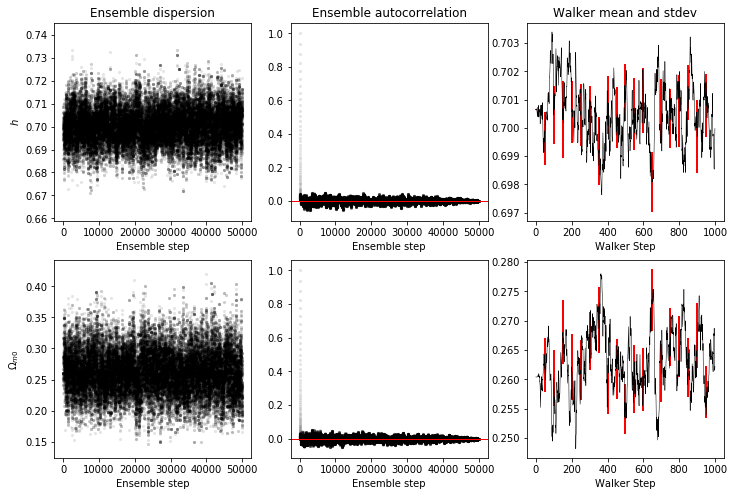

In [21]:
# Functions for priors and loglikelihoods
def lnprior(pars):
    h, omgM = pars
    if 0.0 < h and 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike(pars):
    h, omgM = pars
    return -0.5 * chisq(h, omgM, omgR_fid)

def lnprob(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(pars)

# initial position at maximum likelihood values
ndim, nwalkers, nsteps = 2, 50, 1000
pos = [result_joint.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
sampler.run_mcmc(pos, nsteps)

# Getting chains
h_chain = sampler.chain[:,:,0]
omgM_chain = sampler.chain[:,:,1]

# Average and standard deviation between chains
h_chain_mean = np.mean(h_chain, axis=0)
h_chain_std = np.std(h_chain, axis=0) / np.sqrt(nwalkers)

# Reshaping
h_chain_flat = np.reshape(h_chain, (nwalkers*nsteps,))
omgM_chain_flat = np.reshape(omgM_chain, (nwalkers*nsteps,))

fig = plt.figure(figsize=(12, 8))
axs = fig.subplots(2, 3)

labels = [r"$h$", r"$\Omega_{m0}$"]
samples = np.c_[h_chain_flat, omgM_chain_flat].T
for i, par in enumerate(samples):
    axs[i][0].set_xlabel("Ensemble step")
    axs[i][1].set_xlabel("Ensemble step")
    axs[i][2].set_xlabel("Walker Step")
    axs[i][0].set_ylabel(labels[i])
    axs[0][0].set_title("Ensemble dispersion")
    axs[0][1].set_title("Ensemble autocorrelation")
    axs[0][2].set_title("Walker mean and stdev")
    idx = np.arange(len(par))
    axs[i][0].scatter(idx, par[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    # Obtem autocorrelação usando emcee
    ac = emcee.autocorr.function(par)

    idx = np.arange(len(ac),step=1)
    axs[i][1].scatter(idx, ac[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    axs[i][1].axhline(alpha=1., lw=1., color='red')

h_chain_mean = np.mean(h_chain, axis=0)
h_chain_err = np.std(h_chain, axis=0) / np.sqrt(nwalkers)
omgM_chain_mean = np.mean(omgM_chain, axis=0)
omgM_chain_err = np.std(omgM_chain, axis=0) / np.sqrt(nwalkers)
idx = np.arange(len(h_chain_mean))
axs[0][2].errorbar(x=idx, y=h_chain_mean, yerr=h_chain_err, errorevery=50, ecolor='red',
                   lw=0.5, elinewidth=2., color='k')
axs[1][2].errorbar(x=idx, y=omgM_chain_mean, yerr=omgM_chain_err, errorevery=50, ecolor='red',
                   lw=0.5, elinewidth=2., color='k');

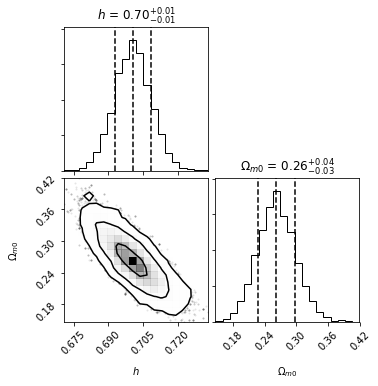

In [22]:
# corner plot
burn = 5000
samples_burned = np.c_[[par[burn:] for par in samples]]
fig = corner.corner(samples_burned.T, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

In [23]:
# Getting one-sigma intervals
samples[:, 2] = np.exp(samples[:, 2])
h_perc = np.percentile(samples[0], [16,50,84])
omgM_perc = np.percentile(samples[1], [16,50,84])

print(h_perc[1], h_perc[0] - h_perc[1], h_perc[2] - h_perc[1])
print(omgM_perc[1], omgM_perc[0] - omgM_perc[1], omgM_perc[2] - omgM_perc[1])

0.7005257770009865 -0.007730075731999242 0.007846094598936926
0.2615353394134282 -0.03411806533120865 0.03626920673565559


$h = 0.7005^{+0.0078}_{-0.0077} \qquad \Omega_{m0} = 0.262^{+0.036}_{-0.034}$